In [2]:
from keras.datasets import fashion_mnist
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import time

Using TensorFlow backend.


In [3]:
# Load and transform training data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
x_train_norm = x_train/255
y_train = np.expand_dims(y_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test_norm = x_test/255
y_test = np.expand_dims(y_test, axis=-1)

# Convert labels to vectors
target_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
binarizer = LabelBinarizer()
y_test_binarized = binarizer.fit_transform(y_test)
y_train_binarized = binarizer.transform(y_train)

# Generate stream of training data
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(x_train)

In [4]:
# Load model
model = load_model('fashion-mnist.model')

In [38]:
# Create model
model = Sequential()


model.add(BatchNormalization(input_shape=x_train.shape[1:]))
# First conv layer
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
# model.add(Dropout(0.1))
model.add(BatchNormalization())

# Second conv layer
model.add(Conv2D(64, 3, padding='same', activation='relu'))
# model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
# model.add(Dropout(0.1))
model.add(BatchNormalization())

# Third conv layer
model.add(Conv2D(128, 3, padding='same', activation='relu'))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(BatchNormalization())

# FC layer
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_48 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_49 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 14, 14, 64)        18496     
__________

In [39]:
# Train model
history = model.fit_generator(datagen.flow(x_train_norm, y_train_binarized, batch_size=32),
                              steps_per_epoch=len(x_train_norm)/32,
                              epochs=40,
                              validation_data=(x_test_norm, y_test_binarized),
                              callbacks=[
                                  EarlyStopping(patience=5, verbose=1),
                                  ModelCheckpoint('fashion-mnist.model', save_best_only=True, verbose=1)
                              ])

Epoch 1/40
1875/1875 [==============================] - 40s 21ms/step - loss: 0.5100 - acc: 0.8189 - val_loss: 0.3483 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.34830, saving model to model.h5
Epoch 2/40
1875/1875 [==============================] - 36s 19ms/step - loss: 0.3340 - acc: 0.8805 - val_loss: 0.2728 - val_acc: 0.9007

Epoch 00002: val_loss improved from 0.34830 to 0.27283, saving model to model.h5
Epoch 3/40
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2951 - acc: 0.8957 - val_loss: 0.2832 - val_acc: 0.8927

Epoch 00003: val_loss did not improve from 0.27283
Epoch 4/40
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2696 - acc: 0.9041 - val_loss: 0.2375 - val_acc: 0.9134

Epoch 00004: val_loss improved from 0.27283 to 0.23746, saving model to model.h5
Epoch 5/40
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2527 - acc: 0.9101 - val_loss: 0.2401 - val_acc: 0.9093

Epoch 00005: val_loss did

In [7]:
# Show the classification report for testing  data
print(model.evaluate(x=x_test_norm, y=y_test_binarized))
probs = model.predict(x_test_norm)
preds = np.argmax(probs,axis=1)
print(classification_report(y_test, 
                      preds, 
                      target_names=target_names)
     )

10000/10000 [==============================] - 2s 154us/step
[0.1819636699706316, 0.9385]
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.89      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.94      0.94      0.94      1000
        Coat       0.88      0.94      0.91      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.85      0.80      0.82      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



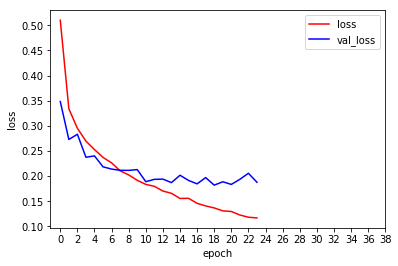

In [43]:
# Plot the history of loss and val_loss during training
plt.plot(history.history['loss'], color='r', label='loss')
plt.plot(history.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.xticks(np.arange(20)*2)
plt.xlabel('epoch')
plt.ylabel('loss')

# Save history
with open('history'+str(time.clock()),'wb') as h:
    pickle.dump(history.history, h)

prediction: Ankle boot, truth: Ankle boot


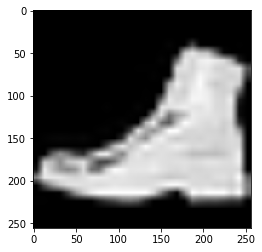

In [13]:
# Display sample image and classification
i = np.random.choice(np.arange(len(x_test)), size=1)[0]
img = x_test[i]
class_i = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=1)[0]
class_name = target_names[class_i]
img = cv2.resize(img, (256,256))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
print('prediction: {}, truth: {}'.format(class_name, target_names[y_test[i][0]]))
plt.imshow(img)